In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from itertools import product
import seaborn as sns

from utils.data_acquisition import  fetch_housing_dataset, fetch_wine_dataset
from utils.metrics import mse, accuracy_score, precision_score, recall_score, f1_score
from utils.data_preparation import remove_outliers, min_max_scale, k_fold_split
from models.models import LinearRegression, LogisticRegression
from models.optimizers import GradientDescent, StochasticGradientDescent

## Data Loading


In [2]:
SEED = 0
np.random.seed(SEED)

HOUSING_DF = fetch_housing_dataset()
WINE_DF = fetch_wine_dataset()

# Experiment 1: Basic Performance Comparison

For both datasets, perform an 80/20 train/test split and report the performance metrics on both the training set and test set for each model. Please include metrics such as Mean Squared Error (MSE) for Linear Regression and accuracy, precision, recall, and F1-score for Logistic Regression

### Data Preparation

In [32]:
TEST_SIZE = 0.2
IQR_FACTOR = 1.5

housing_df = HOUSING_DF.copy()
wine_df = WINE_DF.copy()

### Data Cleaning ###
# remove outliers (but not for CHAS bc it is 1/0)
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

wine_df_cleaned = remove_outliers(wine_df, factor=IQR_FACTOR)

### Data Splitting ###
# perform train test split
X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                    housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), test_size=TEST_SIZE)

one_hot_wine_classes = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(wine_df_cleaned.drop(['class'], axis=1).to_numpy(),
                                                                        one_hot_wine_classes,
                                                                        test_size=TEST_SIZE)

### Data Normalization ###
# normalize data after train test split to prevent data leakage
#X_wine_train, X_wine_test = min_max_scale(X_wine_train, X_wine_test)
X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test)

### Linear Regression

Memory consumption for analytical linear regression model: 56 bytes
Memory consumption for mini-batch SGD model: 56 bytes
L2 norm between best weights and SGD weights: 5225.9
Mean squarred error from analytic fit: 6.983
Mean squared error from SGD with mini-batch size 32: 13.499
Time taken for analytic fit: 0.00256 seconds
Time taken for SGD fit: 1.99914 seconds


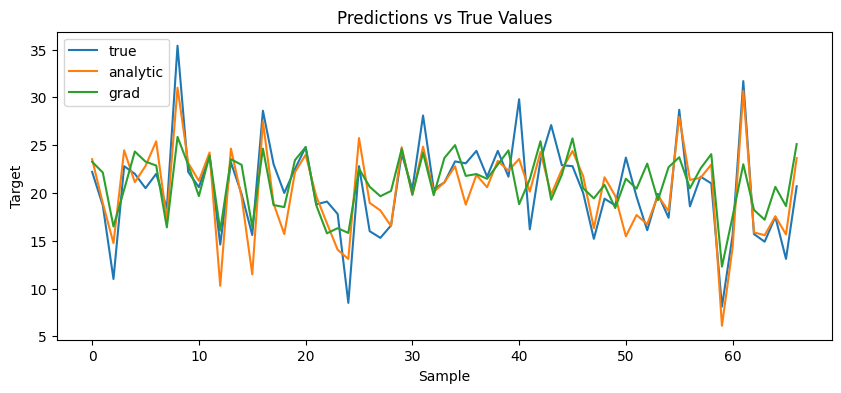

In [39]:
OPTIMIZER_KWARGS = {
    'batch_size': 32,
    'learning_rate': 0.1,
    'max_iters': 1e5,
    'verbose': False
}

# analytic fit
start_time_analytic = time.time()
lin_reg = LinearRegression()
lin_reg.fit(X_housing_train, y_housing_train, analytic_fit=True, verbose=False)
end_time_analytic = time.time()

y_preds_with_analytic_fit = lin_reg.predict(X_housing_test)
min_ms_error = mse(y_housing_test, lin_reg.predict(X_housing_test))
w_analytic = np.copy(lin_reg.w)

# mini-batch SGD fit
start_time_sgd = time.time()
log_reg = LogisticRegression()
lin_reg.fit(X_housing_train, y_housing_train, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
y_preds_with_grad = lin_reg.predict(X_housing_test)
ms_error = mse(y_housing_test, y_preds_with_grad)
end_time_sgd = time.time()

# Calculate the execution time for each fit
time_analytic = end_time_analytic - start_time_analytic
time_sgd = end_time_sgd - start_time_sgd

### Results ###
print(f"L2 norm between best weights and SGD weights: {np.linalg.norm(w_analytic - lin_reg.w):.5g}")
print(f"Mean squarred error from analytic fit: {min_ms_error:.5g}")
print(f"Mean squared error from SGD with mini-batch size {OPTIMIZER_KWARGS['batch_size']}: {ms_error:.5g}")

# Print the execution times
print(f"Time taken for analytic fit: {time_analytic:.5f} seconds")
print(f"Time taken for SGD fit: {time_sgd:.5f} seconds")

plt.figure(figsize=(10,4))
plt.plot(y_housing_test, label='true')
plt.plot(y_preds_with_analytic_fit, label='analytic')
plt.plot(y_preds_with_grad, label='grad')
plt.title('Predictions vs True Values')
plt.xlabel('Sample')
plt.ylabel('Target')
plt.legend()
plt.show()

### Logistic Regression

In [34]:
BATCH_SIZE = 32
OPTIMIZER_KWARGS = {
    'max_iters': 1e5,
    'learning_rate': 0.05,
    'verbose': False
    }

# GD fit
log_reg = LogisticRegression()
log_reg.fit(X_wine_train, y_wine_train, optimizer_class=GradientDescent, **OPTIMIZER_KWARGS)
y_wine_preds_gd = log_reg.predict(X_wine_test)
w_gd = np.copy(log_reg.w)

gd_accuracy = accuracy_score(y_wine_test, y_wine_preds_gd)
gd_recall = recall_score(y_wine_test, y_wine_preds_gd)
gd_precision = precision_score(y_wine_test, y_wine_preds_gd)
gd_f1_score = f1_score(y_wine_test, y_wine_preds_gd)

# mini-batch SGD fit
log_reg = LogisticRegression()
log_reg.fit(X_wine_train, y_wine_train, optimizer_class=StochasticGradientDescent, batch_size=BATCH_SIZE, **OPTIMIZER_KWARGS)
y_wine_preds_sgd = log_reg.predict(X_wine_test)
w_sgd = np.copy(log_reg.w)

sgd_accuracy = accuracy_score(y_wine_test, y_wine_preds_sgd)
sgd_recall = recall_score(y_wine_test, y_wine_preds_sgd)
sgd_precision = precision_score(y_wine_test, y_wine_preds_sgd)
sgd_f1_score = f1_score(y_wine_test, y_wine_preds_sgd)

print("L2 norm between sgd weights and mini-batch weights: ", np.linalg.norm(w_gd - w_sgd))
print(f"Accuracy:\n \tGD: {gd_accuracy:.5g}, SGD with mini-batch of size {BATCH_SIZE}: {sgd_accuracy:.5g}")
print(f"Recall:\n \tGD: {gd_recall:.5g}, SGD with mini-batch of size {BATCH_SIZE}: {sgd_recall:.5g}")
print(f"Precision:\n \tGD: {gd_precision:.5g}, SGD with mini-batch of size {BATCH_SIZE}: {sgd_precision:.5g}")
print(f"F1 score:\n \tGD: {gd_f1_score:.5g}, SGD with mini-batch of size {BATCH_SIZE}: {sgd_f1_score:.5g}")

L2 norm between sgd weights and mini-batch weights:  395.7576557616178
Accuracy:
 	GD: 1, SGD with mini-batch of size 32: 0.93939
Recall:
 	GD: 1, SGD with mini-batch of size 32: 0.93939
Precision:
 	GD: 1, SGD with mini-batch of size 32: 0.9452
F1 score:
 	GD: 1, SGD with mini-batch of size 32: 0.93817


### Results

**Linear Regression**
- analytical solution of linear regression performs much better (6 vs 12 MSE)

**Logistic Regression**
- Logistic Regression performs really well on the data
- SGD works better than GD with BS 64
- with BS 8, SGD performs worse than GD

# Experiment 2: Cross-Validation

For both data sets, use a 5-fold cross-validation technique and report the performance metrics on both the training set and test set for each model. Again, include appropriate performance metrics for each model. Check this link for more information.

Note: 5-fold cross-validation is a technique where the dataset is divided into five equal parts (folds), and a model is trained and evaluated five times, each time using a different fold as the validation set and the remain- ing four folds for training.


### Data Preparation

In [ ]:
IQR_FACTOR = 1.5 

housing_df = HOUSING_DF.copy()
wine_df = WINE_DF.copy()

### Data Cleaning ###
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

wine_df_cleaned = remove_outliers(wine_df, factor=IQR_FACTOR)

X_housing = housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy()
y_housing = housing_df_cleaned.MEDV.to_numpy().reshape(-1,1)

X_wine = wine_df_cleaned.drop(['class'], axis=1).to_numpy()
y_wine = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)

### Linear Regression

In [ ]:
OPTIMIZER_KWARGS = {
    'batch_size': 32,
    'learning_rate': 0.1,
    'max_iters': 1e4,
    'verbose': False
}

errors_analytic_train = []
errors_analytic_test = []
errors_sgd_train = []
errors_sgd_test = []

for X_train_fold, y_train_fold, X_test_fold, y_test_fold in k_fold_split(X_housing, y_housing, n_splits=5):

    # data normalization
    X_train_fold, X_test_fold = min_max_scale(X_train_fold, X_test_fold)

    # analytic fit
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_fold, y_train_fold, analytic_fit=True, verbose=False)
    y_preds_with_analytic_fit_train = lin_reg.predict(X_train_fold)
    y_preds_with_analytic_fit_test = lin_reg.predict(X_test_fold)
    errors_analytic_train.append(mse(y_train_fold, y_preds_with_analytic_fit_train))
    errors_analytic_test.append(mse(y_test_fold, y_preds_with_analytic_fit_test))
    w_analytic = np.copy(lin_reg.w)

    # mini-batch SGD fit
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_fold, y_train_fold, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
    y_preds_with_grad_train = lin_reg.predict(X_train_fold)
    y_preds_with_grad_test = lin_reg.predict(X_test_fold)
    errors_sgd_train.append(mse(y_train_fold, y_preds_with_grad_train))
    errors_sgd_test.append(mse(y_test_fold, y_preds_with_grad_test))

print("Analytic Fit Errors:")
print("Train:", errors_analytic_train)
print("Train Mean:", np.mean(errors_analytic_train))
print("Train Std:", np.std(errors_analytic_train))
print("Test:", errors_analytic_test)
print("Test Mean:", np.mean(errors_analytic_test))
print("Test Std:", np.std(errors_analytic_test))

print("\nMini-Batch SGD Errors:")
print("Train:", errors_sgd_train)
print("Train Mean:", np.mean(errors_sgd_train))
print("Train Std:", np.std(errors_sgd_train))
print("Test:", errors_sgd_test)
print("Test Mean:", np.mean(errors_sgd_test))
print("Test Std:", np.std(errors_sgd_test))

Analytic Fit Errors:
Train: [6.372192267084715, 7.342902925319603, 5.793879094396441, 6.540663300506986, 5.521731089244624]
Train Mean: 6.314273735310474
Train Std: 0.6342900330632179
Test: [7.9708137696004355, 3.77374884543282, 11.745234790995962, 8.652968753532198, 20.008474388885457]
Test Mean: 10.430248109689376
Test Std: 5.421957769396132

Mini-Batch SGD Errors:
Train: [15.283155680803306, 18.58999362427729, 14.260036289048768, 16.865717865140198, 16.783610637382857]
Train Mean: 16.356502819330483
Train Std: 1.481718476585773
Test: [23.571975680870175, 9.227411154096815, 27.438485383983476, 16.711714366514123, 14.965861128755044]
Test Mean: 18.383089542843926
Test Std: 6.437734461212379


### Logistic Regression

In [36]:
BATCH_SIZE = 64
OPTIMIZER_KWARGS = {
    'max_iters': 4e4,
    'learning_rate': 0.05,
    'verbose': False
    }

results_gd_train = []
results_gd_test = []
results_sgd_train = []
results_sgd_test = []

for X_train_fold, y_train_fold, X_test_fold, y_test_fold in k_fold_split(X_wine, y_wine):

    # GD fit
    log_reg = LogisticRegression()
    log_reg.fit(X_train_fold, y_train_fold, optimizer_class=GradientDescent, **OPTIMIZER_KWARGS)

    # metrics
    y_train_preds_gd = log_reg.predict(X_train_fold)
    results_gd_train.append(accuracy_score(y_train_fold, y_train_preds_gd))
    y_test_preds_gd = log_reg.predict(X_test_fold)
    results_gd_test.append(accuracy_score(y_test_fold, y_test_preds_gd))

    # SGD fit
    log_reg = LogisticRegression()
    log_reg.fit(X_train_fold, y_train_fold, optimizer_class=StochasticGradientDescent, batch_size=BATCH_SIZE, **OPTIMIZER_KWARGS)

    # metrixs
    y_train_preds_sgd = log_reg.predict(X_train_fold)
    results_sgd_train.append(accuracy_score(y_train_fold, y_train_preds_sgd))
    y_test_preds_sgd = log_reg.predict(X_test_fold)
    results_sgd_test.append(accuracy_score(y_test_fold, y_test_preds_sgd))

# Computing mean and std for each metric
print("Gradient Descent Results:")
print(f"Train Accuracy: Mean {np.mean(results_gd_train).round(5)}, Std {np.std(results_gd_train).round(5)}")
print(f"Test Accuracy: Mean {np.mean(results_gd_test).round(5)}, Std {np.std(results_gd_test).round(5)}")

print("\nSGD Results:")
print(f"Train Accuracy: Mean {np.mean(results_sgd_train).round(5)}, Std {np.std(results_sgd_train).round(5)}")
print(f"Test Accuracy: Mean {np.mean(results_sgd_test).round(5)}, Std {np.std(results_sgd_test).round(5)}")

Gradient Descent Results:
Train Accuracy: Mean 0.92706, Std 0.04314
Test Accuracy: Mean 0.71288, Std 0.32825

SGD Results:
Train Accuracy: Mean 0.86949, Std 0.05292
Test Accuracy: Mean 0.60114, Std 0.38964


### Results

**Linear Regression**
- anayltic performs better
- both analytic and SGD have std on test set around 5

**Logistic Regression**
- looks a bit like overfitting
- high standard deviation on test set performance

# Experiment 3: Training Set Sizes
For both datasets, Sample growing subsets of the training data (20%,30%,...80%). Observe and explain how does size of training data affects the performance for both models. Plot two curves as a function of training size, one for performance in train and one for test.

### Data Preparation

In [39]:
TEST_SIZE = 0.2
IQR_FACTOR = 1.5 

housing_df = HOUSING_DF.copy()
wine_df = WINE_DF.copy()

### Data Cleaning ###
# remove outliers (but not for CHAS bc it is 1/0)
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

wine_df_cleaned = remove_outliers(wine_df_cleaned, factor=IQR_FACTOR)


### Data Splitting ###
# perform train test split
one_hot_wine_classes = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(wine_df_cleaned.drop(['class'], axis=1).to_numpy(), 
                                                                        one_hot_wine_classes, test_size=TEST_SIZE)

X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                    housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), test_size=TEST_SIZE)

### Data Normalization ###
# normalize data after train test split to prevent data leakage
#X_wine_train, X_wine_test = min_max_scale(X_wine_train, X_wine_test, scale=True)
X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test)

### Linear Regression

53
79
106
133
159
186
212


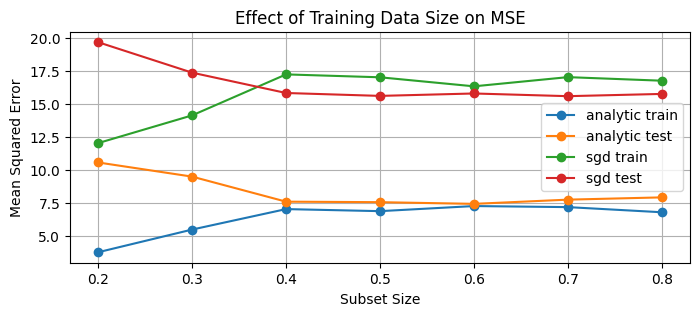

In [38]:
OPTIMIZER_KWARGS = {
    'batch_size': 32,
    'max_iters': 4e4,
    'learning_rate': 0.05,
    'verbose': False
}

# sizes to sample
sizes = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

analytic_train_errors = []
analytic_test_errors = []
sgd_train_errors = []
sgd_test_errors = []

for size in sizes:
    # select data subset
    subset_size = int(size * X_housing_train.shape[0])
    print(subset_size)
    X_train_subset = X_housing_train[:subset_size]
    y_train_subset = y_housing_train[:subset_size]

    lin_reg = LinearRegression()

    # analytic fit
    lin_reg.fit(X_train_subset, y_train_subset, analytic_fit=True, verbose=False)
    y_preds_analytic_train = lin_reg.predict(X_train_subset)
    y_preds_analytic_test = lin_reg.predict(X_housing_test)
    analytic_train_errors.append(mse(y_train_subset, y_preds_analytic_train))
    analytic_test_errors.append(mse(y_housing_test, y_preds_analytic_test))

    # mini-batch SGD fit
    lin_reg.fit(X_train_subset, y_train_subset, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
    y_preds_sgd_train = lin_reg.predict(X_train_subset)
    y_preds_sgd_test = lin_reg.predict(X_housing_test)
    sgd_train_errors.append(mse(y_train_subset, y_preds_sgd_train))
    sgd_test_errors.append(mse(y_housing_test, y_preds_sgd_test))

plt.figure(figsize=(8,3))
plt.plot(sizes, analytic_train_errors, '-o',label='analytic train')
plt.plot(sizes, analytic_test_errors, '-o',label='analytic test')
plt.plot(sizes, sgd_train_errors, '-o',label='sgd train')
plt.plot(sizes, sgd_test_errors, '-o',label='sgd test')
plt.xlabel('Subset Size')
plt.ylabel('Mean Squared Error')
plt.title('Effect of Training Data Size on MSE')
plt.grid(True)
plt.legend()
plt.show()


### Logistic Regression

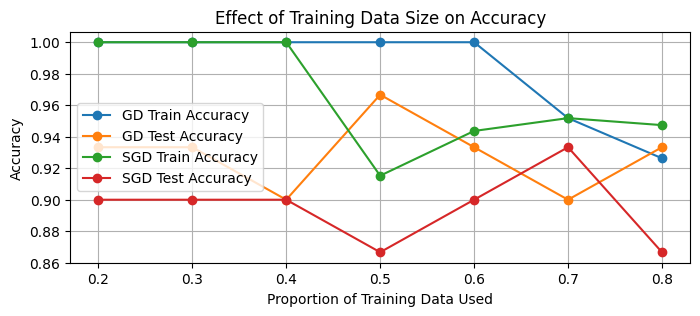

In [42]:
BATCH_SIZE = 16
OPTIMIZER_KWARGS = {'max_iters': 1e5,
                    'learning_rate': 0.05,
                    'verbose': False}

# sizes to sample
sizes = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

gd_train_accuracies = []
gd_test_accuracies = []
sgd_train_accuracies = []
sgd_test_accuracies = []

for size in sizes:
    # select data subset
    subset_size = int(size * X_wine_train.shape[0])
    X_train_subset = X_wine_train[:subset_size]
    y_train_subset = y_wine_train[:subset_size]
    
    # GD fit
    log_reg.fit(X_train_subset, y_train_subset, optimizer_class=GradientDescent, **OPTIMIZER_KWARGS)
    gd_train_accuracies.append(accuracy_score(y_train_subset, log_reg.predict(X_train_subset)))
    gd_test_accuracies.append(accuracy_score(y_wine_test, log_reg.predict(X_wine_test)))
    
    # mini-batch SGD fit
    log_reg.fit(X_train_subset, y_train_subset, optimizer_class=StochasticGradientDescent, batch_size=BATCH_SIZE, **OPTIMIZER_KWARGS)
    sgd_train_accuracies.append(accuracy_score(y_train_subset, log_reg.predict(X_train_subset)))
    sgd_test_accuracies.append(accuracy_score(y_wine_test, log_reg.predict(X_wine_test)))

plt.figure(figsize=(8, 3))
plt.plot(sizes, gd_train_accuracies, '-o', label="GD Train Accuracy")
plt.plot(sizes, gd_test_accuracies, '-o', label="GD Test Accuracy")
plt.plot(sizes, sgd_train_accuracies, '-o', label="SGD Train Accuracy")
plt.plot(sizes, sgd_test_accuracies, '-o', label="SGD Test Accuracy")
plt.xlabel("Proportion of Training Data Used")
plt.ylabel("Accuracy")
plt.title("Effect of Training Data Size on Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### Results

**Linear Regression**
- generalization performance increases with more data for analytical solution
- for SGD starting with 40%, performance is really stable independent of the amount of data

**Logistic Regression**
- performance peak already with only 40% of the data for training 
- logistic regression performance decreases afterwards
- linear regression stays on some sort of plateau, indicating that not more data is needed
- another time it helps for both

# Experiment 4: Minibatch Sizes
For both datasets, try out growing minibatch sizes, e.g., 8, 16, 32, 64, and 128. Compare the convergence speed and final performance of different batch sizes to the fully batched baseline. Which configuration works the best among the ones you tried?
Note: This is for SGD only (Task2, third main task).

### Data Preparation

In [44]:
TEST_SIZE = 0.2
IQR_FACTOR = 1.5

housing_df = HOUSING_DF.copy()
wine_df = WINE_DF.copy()

### Data Cleaning ###
# remove outliers (but not for CHAS bc it is 1/0)
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

wine_df_cleaned = remove_outliers(wine_df_cleaned, factor=IQR_FACTOR)

### Data Splitting ###
# perform train test split
one_hot_wine_classes = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(wine_df_cleaned.drop(['class'], axis=1).to_numpy(), 
                                                                        one_hot_wine_classes, test_size=TEST_SIZE)

X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                    housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), test_size=TEST_SIZE)

### Data Normalization ###
# normalize data after train test split to prevent data leakage
#X_wine_train, X_wine_test = min_max_scale(X_wine_train, X_wine_test, scale=True)
X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test)

### Linear Regression

In [45]:
OPTIMIZER_KWARGS = {
    'max_iters': 4e4,
    'learning_rate': 0.1,
    'verbose': False}

batch_sizes = [1, 4, 8, 16, 32, 64, 128, X_housing_train.shape[0]]

sgd_train_errors = []
sgd_test_errors = []
convergence_speeds = []

for batch_size in batch_sizes:
    lin_reg = LinearRegression()

    start_time = time.time()
    lin_reg.fit(X_housing_train, y_housing_train, optimizer_class=StochasticGradientDescent, batch_size=batch_size, **OPTIMIZER_KWARGS)
    end_time = time.time()
    
    y_preds_with_grad_train = lin_reg.predict(X_housing_train)
    y_preds_with_grad_test = lin_reg.predict(X_housing_test)
    sgd_train_errors.append(mse(y_housing_train, y_preds_with_grad_train))
    sgd_test_errors.append(mse(y_housing_test, y_preds_with_grad_test))
    convergence_speeds.append(end_time - start_time)

for batch_size, train_error, test_error, speed in zip(batch_sizes, sgd_train_errors, sgd_test_errors, convergence_speeds):
    print(f"Batch Size: {batch_size}, Train Error: {train_error:.5g}, Test Error: {test_error:.5g}, Convergence Speed: {speed:.3g} seconds")

Batch Size: 1, Train Error: 14.336, Test Error: 17.386, Convergence Speed: 3.21 seconds
Batch Size: 4, Train Error: 14.782, Test Error: 18.837, Convergence Speed: 3.01 seconds
Batch Size: 8, Train Error: 14.49, Test Error: 18.079, Convergence Speed: 2.88 seconds
Batch Size: 16, Train Error: 14.389, Test Error: 17.889, Convergence Speed: 3.01 seconds
Batch Size: 32, Train Error: 14.358, Test Error: 17.356, Convergence Speed: 3.15 seconds
Batch Size: 64, Train Error: 14.327, Test Error: 17.462, Convergence Speed: 3.07 seconds
Batch Size: 128, Train Error: 14.33, Test Error: 17.482, Convergence Speed: 3.5 seconds
Batch Size: 266, Train Error: 14.328, Test Error: 17.486, Convergence Speed: 3.78 seconds


### Logistic Regression

In [23]:
OPTIMIZER_KWARGS = {
    'max_iters': 4e4,
    'learning_rate': 0.05,
    'verbose': False}

batch_sizes = [8, 16, 32, 64, X_wine_train.shape[0]]  


sgd_train_accuracies = []
sgd_test_accuracies = []
convergence_speeds = []

for batch_size in batch_sizes:
    log_reg = LogisticRegression()
    
    # mini-batch SGD fit
    start_time = time.time()
    log_reg.fit(X_wine_train, y_wine_train, optimizer_class=StochasticGradientDescent, batch_size=batch_size, **OPTIMIZER_KWARGS)
    end_time = time.time()
    
    sgd_train_accuracies.append(accuracy_score(y_wine_train, log_reg.predict(X_wine_train)))
    sgd_test_accuracies.append(accuracy_score(y_wine_test, log_reg.predict(X_wine_test)))
    convergence_speeds.append(end_time - start_time)

for batch_size, train_acc, test_acc, speed in zip(batch_sizes, sgd_train_accuracies, sgd_test_accuracies, convergence_speeds):
    print(f"Batch size {batch_size}: Train Acc: {train_acc:.5g}, Test Acc: {test_acc:5g}, Convergence Time: {speed:.3g} seconds")

Batch size 8: Train Acc: 0.85714, Test Acc: 0.833333, Convergence Time: 5.62 seconds
Batch size 16: Train Acc: 0.85714, Test Acc:   0.8, Convergence Time: 5.62 seconds
Batch size 32: Train Acc: 0.94118, Test Acc:   0.9, Convergence Time: 5.94 seconds
Batch size 64: Train Acc: 0.80672, Test Acc:   0.7, Convergence Time: 6.7 seconds
Batch size 119: Train Acc: 0.94958, Test Acc: 0.933333, Convergence Time: 8.03 seconds


### Results

**Linear Regression**
- does not really matter

**Logistic Regression**
- best performance with Gradient Descent (whole data set as batch)
- converence fastest with batch size 16, but all very close

# Experiment 5: Different Learning Rates
For both datasets, Present the performance of both linear and logistic regression with at least three different learning rates (your own choice).

### Data Preparation

In [24]:
TEST_SIZE = 0.2
IQR_FACTOR = 1.5

housing_df = HOUSING_DF.copy()
wine_df = WINE_DF.copy()

### Data Cleaning ###
#remove outliers (but not for CHAS bc it is 1/0)
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

wine_df_cleaned = remove_outliers(wine_df, factor=IQR_FACTOR)

### Data Splitting ###
# perform train test split
X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                    housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), test_size=TEST_SIZE)

one_hot_wine_classes = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(wine_df_cleaned.drop(['class'], axis=1).to_numpy(),
                                                                        one_hot_wine_classes,
                                                                        test_size=TEST_SIZE)


### Data Normalization ###
# normalize data after train test split to prevent data leakage
X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test)
#X_wine_train, X_wine_test = min_max_scale(X_wine_train, X_wine_test)

### Linear Regression

Learning Rate: 0.005, Train Error: 17.018, Test Error: 19.876
Learning Rate: 0.01, Train Error: 16.179, Test Error: 18.626
Learning Rate: 0.05, Train Error: 14.385, Test Error: 15.926
Learning Rate: 0.1, Train Error: 13.140, Test Error: 14.614
Learning Rate: 0.2, Train Error: 11.678, Test Error: 12.373
Learning Rate: 0.5, Train Error: 11.610, Test Error: 10.733
Learning Rate: 0.7, Train Error: 10.348, Test Error: 10.341
Learning Rate: 1.0, Train Error: 10.417, Test Error: 10.440


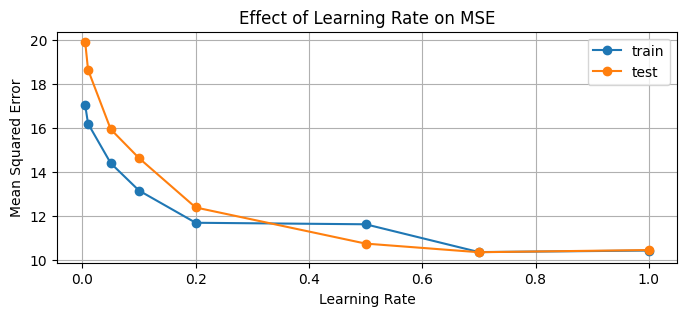

In [25]:
OPTIMIZER_KWARGS = {
    'batch_size': 32, 
    'max_iters': 1e5, 
    'verbose': False
    }
LEARNING_RATES = [0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 1.0]

train_errors = []
test_errors = []

for lr in LEARNING_RATES:
    lin_reg = LinearRegression()

    lin_reg.fit(X_housing_train, y_housing_train, optimizer_class=StochasticGradientDescent, learning_rate=lr, **OPTIMIZER_KWARGS)
    
    y_preds_train = lin_reg.predict(X_housing_train)
    y_preds_test = lin_reg.predict(X_housing_test)
    train_errors.append(mse(y_housing_train, y_preds_train))
    test_errors.append(mse(y_housing_test, y_preds_test))

    print(f"Learning Rate: {lr}, Train Error: {train_errors[-1]:.3f}, Test Error: {test_errors[-1]:.3f}")

# plot results of different learning rates
plt.figure(figsize=(8,3))
plt.plot(LEARNING_RATES, train_errors, '-o',label='train')
plt.plot(LEARNING_RATES, test_errors, '-o',label='test')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Effect of Learning Rate on MSE')
plt.grid(True)
plt.show()


In [26]:
print(1e5)

100000.0


### Logistic Regression

Learning Rate: 0.005, Train Accuracy: 0.906, Test Accuracy: 0.909
Learning Rate: 0.01, Train Accuracy: 0.945, Test Accuracy: 0.939
Learning Rate: 0.05, Train Accuracy: 0.938, Test Accuracy: 0.970
Learning Rate: 0.1, Train Accuracy: 0.938, Test Accuracy: 0.909
Learning Rate: 0.2, Train Accuracy: 0.914, Test Accuracy: 0.970
Learning Rate: 0.5, Train Accuracy: 0.938, Test Accuracy: 0.909
Learning Rate: 0.7, Train Accuracy: 0.930, Test Accuracy: 0.939
Learning Rate: 1.0, Train Accuracy: 0.938, Test Accuracy: 0.970


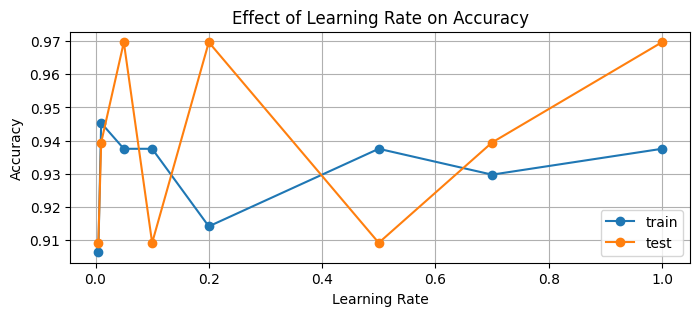

In [27]:
OPTIMIZER_KWARGS = {
    'batch_size': 64, 
    'max_iters': 1e5, 
    'verbose': False
    }
LEARNING_RATES = [0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 1.0]

train_accuracies = []
test_accuracies = []

for lr in LEARNING_RATES:
    log_reg = LogisticRegression()

    log_reg.fit(X_wine_train, y_wine_train, optimizer_class=StochasticGradientDescent, learning_rate=lr, **OPTIMIZER_KWARGS)
    
    y_preds_train = log_reg.predict(X_wine_train)
    y_preds_test = log_reg.predict(X_wine_test)
    train_accuracies.append(accuracy_score(y_wine_train, y_preds_train))
    test_accuracies.append(accuracy_score(y_wine_test, y_preds_test))

    print(f"Learning Rate: {lr}, Train Accuracy: {train_accuracies[-1]:.3f}, Test Accuracy: {test_accuracies[-1]:.3f}")

# plot results of different learning rates
plt.figure(figsize=(8,3))
plt.plot(LEARNING_RATES, train_accuracies, '-o',label='train')
plt.plot(LEARNING_RATES, test_accuracies, '-o',label='test')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Effect of Learning Rate on Accuracy')
plt.grid(True)
plt.show()

### Results

**Linear Regression**
- the higher the learning rate, the lower the error
- goes up again a bit after 0.7
- best performance with learning rate 0.7

**Logistic Regression**
- much more unstable, no clear trend
- best performance with learning rate 0.2

# Experiment 6: Different Parameter Configurations
For both datasets, Given a variety of parameter configurations, select a performance metric and present the optimal parameter choice for each dataset. Please provide a rationale for your metric selection, along with an explanation of why you opted for that particular metric

### Linear Regression

In [8]:
PARAM_GRID = {
    'IQR_FACTOR': [1.0, 1.5, 2.0],
    'BATCH_SIZE': [1, 8, 32, 64],
    'LEARNING_RATE': [0.05, 0.1, 0.5],
    'MAX_ITERS': [1e4, 1e5],
    'MOMENTUM': [0.0, 0.5, 0.9]
}
TEST_SIZE = 0.2

print(f"Number of combinations: {len(list(product(*PARAM_GRID.values())))}")

housing_df = HOUSING_DF.copy()

count = 1
housing_param_search_results = []

for params in product(*PARAM_GRID.values()):
    IQR_FACTOR = params[0]
    OPTIMIZER_KWARGS = {
        'batch_size': params[1],
        'learning_rate': params[2],
        'max_iters': params[3],
        'beta': params[4],
        'verbose': False
    }

    ### Data Cleaning ###
    temp_df = housing_df.drop(columns='CHAS')
    temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
    housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

    ### Data Splitting ###
    # split into train and test sets
    X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                        housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), test_size=TEST_SIZE)

    for X_train_fold, y_train_fold, X_test_fold, y_test_fold in k_fold_split(X_housing_train, y_housing_train, n_splits=3):

        mse_train = []
        mse_val = []

        ### Data Normalization ###
        X_train_fold, X_test_fold = min_max_scale(X_train_fold, X_test_fold)

        lin_reg = LinearRegression()

        start_time = time.time()
        lin_reg.fit(X_train_fold, y_train_fold, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
        end_time = time.time()

        y_preds_sgd_train = lin_reg.predict(X_train_fold)
        y_preds_sgd_val = lin_reg.predict(X_test_fold)
        mse_train.append(mse(y_train_fold, y_preds_sgd_train))
        mse_val.append(mse(y_test_fold, y_preds_sgd_val))

    # data normalization
    X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test)

    lin_reg = LinearRegression()
    lin_reg.fit(X_housing_train, y_housing_train, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
    mse_test = mse(y_housing_test, lin_reg.predict(X_housing_test))

    # save results
    param_dict = dict(zip(PARAM_GRID.keys(), params))
    result_dict = {
        'IQR Factor': param_dict['IQR_FACTOR'],
        'Batch Size': param_dict['BATCH_SIZE'],
        'Learning Rate': param_dict['LEARNING_RATE'],
        'Max Iters': param_dict['MAX_ITERS'],
        'Momentum': param_dict['MOMENTUM'],
        'Mean Train MSE': np.mean(mse_train).round(3),
        'Mean Validation MSE': np.mean(mse_val).round(3),
        'Test MSE': mse_test.round(3),
        'Convergence Speed': np.round((end_time - start_time), 4)
    }
    housing_param_search_results.append(result_dict)

    print(f"{count}: Params: {params}, Mean Val MSE: {np.mean(mse_val).round(3)}, Test MSE: {mse_test.round(3)}, Speed: {np.round((end_time - start_time), 2)}s")
    count += 1

Number of combinations: 216
1: Params: (1.0, 1, 0.05, 10000.0, 0.0), Mean Val MSE: 10.375, Test MSE: 16.564, Speed: 0.85s
2: Params: (1.0, 1, 0.05, 10000.0, 0.5), Mean Val MSE: 16.691, Test MSE: 10.026, Speed: 0.8s
3: Params: (1.0, 1, 0.05, 10000.0, 0.9), Mean Val MSE: 13.229, Test MSE: 19.089, Speed: 1.08s
4: Params: (1.0, 1, 0.05, 100000.0, 0.0), Mean Val MSE: 10.26, Test MSE: 12.203, Speed: 9.01s
5: Params: (1.0, 1, 0.05, 100000.0, 0.5), Mean Val MSE: 13.796, Test MSE: 11.942, Speed: 7.99s
6: Params: (1.0, 1, 0.05, 100000.0, 0.9), Mean Val MSE: 10.081, Test MSE: 11.986, Speed: 7.99s
7: Params: (1.0, 1, 0.1, 10000.0, 0.0), Mean Val MSE: 13.003, Test MSE: 15.165, Speed: 0.8s
8: Params: (1.0, 1, 0.1, 10000.0, 0.5), Mean Val MSE: 15.493, Test MSE: 12.259, Speed: 0.8s
9: Params: (1.0, 1, 0.1, 10000.0, 0.9), Mean Val MSE: 13.513, Test MSE: 12.347, Speed: 0.82s
10: Params: (1.0, 1, 0.1, 100000.0, 0.0), Mean Val MSE: 15.99, Test MSE: 6.586, Speed: 7.99s
11: Params: (1.0, 1, 0.1, 100000.0, 0

In [20]:
# TODO plot results for different parameters
housing_param_search_results_df = pd.DataFrame(housing_param_search_results)

# save results
housing_param_search_results_df.to_csv('results/6/param_search_housing.csv', index=False)

NameError: name 'housing_param_search_results' is not defined

In [21]:
# load dataframe
housing_param_search_results_df = pd.read_csv('results/6/param_search_housing.csv')

# plot top 10 rows with highest validation mse
housing_param_search_results_df.sort_values(by='Mean Validation MSE', ascending=True).head(20)

,IQR Factor,Batch Size,Learning Rate,Max Iters,Momentum,Mean Train MSE,Mean Validation MSE,Test MSE,Convergence Speed
53,1.0,32,0.50,100000.0,0.9,8.060,6.474,8.592,8.31
71,1.0,64,0.50,100000.0,0.9,8.561,6.808,6.408,9.34
69,1.0,64,0.50,100000.0,0.0,7.936,7.455,9.044,9.46
52,1.0,32,0.50,100000.0,0.5,7.676,7.497,9.458,8.36
15,1.0,1,0.50,100000.0,0.0,6.655,7.858,11.107,9.45
27,1.0,8,0.10,100000.0,0.0,10.819,8.435,11.441,7.79
106,1.5,8,0.50,100000.0,0.5,11.263,8.654,11.288,8.02
32,1.0,8,0.50,10000.0,0.9,12.402,8.855,13.796,0.85
48,1.0,32,0.50,10000.0,0.0,11.934,8.941,12.302,0.84
123,1.5,32,0.50,100000.0,0.0,10.710,9.074,13.152,8.83


Learning Rate
0.05    9.203
0.10    8.435
0.50    6.474
Name: Mean Validation MSE, dtype: float64


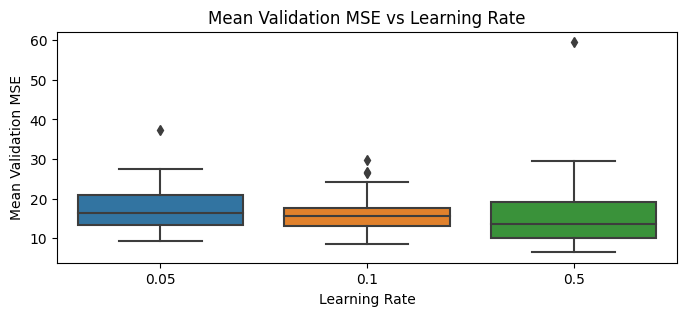

Learning Rate
0.05    7.601
0.10    6.586
0.50    6.408
Name: Test MSE, dtype: float64


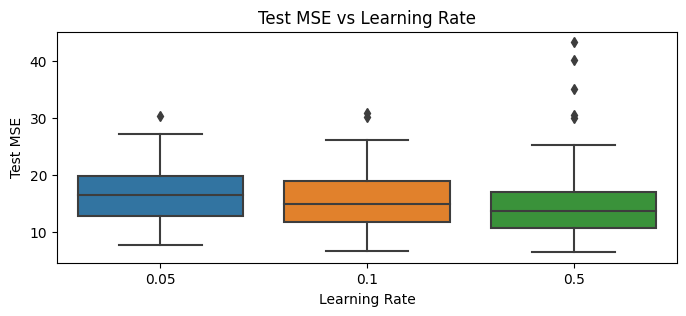

In [24]:
# validation mse
print(housing_param_search_results_df.groupby('Learning Rate')['Mean Validation MSE'].min())
plt.figure(figsize=(8,3))
sns.boxplot(x='Learning Rate', y='Mean Validation MSE', data=housing_param_search_results_df)
plt.title('Mean Validation MSE vs Learning Rate')
plt.show()

# test mse
print(housing_param_search_results_df.groupby('Learning Rate')['Test MSE'].min())
plt.figure(figsize=(8,3))
sns.boxplot(x='Learning Rate', y='Test MSE', data=housing_param_search_results_df)
plt.title('Test MSE vs Learning Rate')
plt.show()

### Logistic Regression

In [17]:
PARAM_GRID = {
    'IQR_FACTOR': [1.0, 1.5, 2.0],
    'BATCH_SIZE': [1, 8, 32, 64, 128],
    'LEARNING_RATE': [0.01, 0.1, 0.5],
    'MAX_ITERS': [1e4, 1e5],
    'MOMENTUM': [0.0, 0.5, 0.9]
}
TEST_SIZE = 0.20

print(f"Number of combinations: {len(list(product(*PARAM_GRID.values())))}")

wine_df = WINE_DF.copy()

count = 1
wine_param_search_results = []

for params in product(*PARAM_GRID.values()):
    IQR_FACTOR = params[0]
    OPTIMIZER_KWARGS = {
        'batch_size': params[1],
        'learning_rate': params[2],
        'max_iters': params[3],
        'beta': params[4],
        'verbose': False
    }

    ### Data Cleaning ###
    wine_df_cleaned = remove_outliers(wine_df, factor=IQR_FACTOR)

    ### Data Splitting ###
    one_hot_wine_classes = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)
    X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(wine_df_cleaned.drop(['class'], axis=1).to_numpy(), 
                                                                        one_hot_wine_classes, test_size=TEST_SIZE)
    
    acc_train = []
    acc_val = []
    
    for X_train_fold, y_train_fold, X_test_fold, y_test_fold in k_fold_split(X_wine_train, y_wine_train, n_splits=3):

        log_reg = LogisticRegression()

        start_time = time.time()
        log_reg.fit(X_train_fold, y_train_fold, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
        end_time = time.time()

        y_preds_sgd_train = log_reg.predict(X_train_fold)
        y_preds_sgd_val = log_reg.predict(X_test_fold)
        acc_train.append(accuracy_score(y_train_fold, y_preds_sgd_train))
        acc_val.append(accuracy_score(y_test_fold, y_preds_sgd_val))

    log_reg = LogisticRegression()
    log_reg.fit(X_wine_train, y_wine_train, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
    acc_test = accuracy_score(y_wine_test, log_reg.predict(X_wine_test))

    # save results
    param_dict = dict(zip(PARAM_GRID.keys(), params))
    result_dict = {
        'IQR Factor': param_dict['IQR_FACTOR'],
        'Batch Size': param_dict['BATCH_SIZE'],
        'Learning Rate': param_dict['LEARNING_RATE'],
        'Max Iters': param_dict['MAX_ITERS'],
        'Momentum': param_dict['MOMENTUM'],
        'Mean Train Accuracy': np.mean(acc_train).round(3),
        'Mean Validation Accuracy': np.mean(acc_val).round(3),
        'Test Accuracy': acc_test.round(3),
        'Convergence Speed': np.round((end_time - start_time), 4)
    }
    wine_param_search_results.append(result_dict)

    print(f"{count}: Params: {params}, Mean Val Acc: {np.mean(acc_val).round(3)}, Test Acc: {acc_test.round(3)}, Speed: {np.round((end_time - start_time), 4)}s")
    count += 1

Number of combinations: 270
1: Params: (1.0, 1, 0.01, 10000.0, 0.0), Mean Val Acc: 0.56, Test Acc: 0.875, Speed: 1.2981s
2: Params: (1.0, 1, 0.01, 10000.0, 0.5), Mean Val Acc: 0.574, Test Acc: 0.75, Speed: 1.2497s
3: Params: (1.0, 1, 0.01, 10000.0, 0.9), Mean Val Acc: 0.681, Test Acc: 0.667, Speed: 1.2758s


KeyboardInterrupt: 

In [ ]:
# TODO plot results for different parameters
wine_param_search_results_df = pd.DataFrame(wine_param_search_results)

# save results
wine_param_search_results_df.to_csv('results/6/param_search_wine.csv', index=False)

### Results

**Linear Regression**
- Best Params: 
    - IQR factor: 1.0
    - Batch Size: 32
    - Learning Rate: 0.5
    - Max Epochs: 100000
    - Momentum: 0.5
    - Test MSE: 5.778

**Logistic Regression**
- x

# Experiment 7: Gaussian Basis Functions

Only for dataset1, Gaussian Basis Functions:
- Utilize Gaussian basis functions to enrich the feature set for Dataset 1. • Define each Gaussian basis function as follows:
  
$$\phi_j(x) = exp(-\frac{||x-\mu_j||^2}{2s^2})$$

- Employ a total of 5 Gaussian basis functions.
- Set the spatial scale parameter, s, to a value of 1.
- Select μj values randomly from the training set to determine the centers of these basis functions.
- Use analytical linear regression to predict the target value.
- Compare the target and predicted values obtained with the new dataset with the results obtained with the original feature set, i.e. compare with the results obtained without Gaussian basis functions.

### Data Preparation

In [39]:
IQR_FACTOR = 1.5
TEST_SIZE = 0.2

housing_df = HOUSING_DF.copy()
wine_df = WINE_DF.copy()

### Data Cleaning ###
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

### Data Splitting ###
X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                    housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), test_size=TEST_SIZE)
### Data Normalization ###
X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test)


In [42]:
num_basis_functions = 5
s = 1.0
feature_index = 0

def calculate_gaussian_basis_functions(x, mu_values, s):
    return [np.exp(-np.linalg.norm(x - mu)**2 / (2 * s**2)) for mu in mu_values]

def compute_basis_features(X, feature_index, mu_values, s):
    num_samples = X.shape[0]
    basis_features = np.empty((num_samples, num_basis_functions))
    for i in range(num_samples):
        basis_features[i, :] = calculate_gaussian_basis_functions(X[i, feature_index], mu_values, s)
    return basis_features

# select random indices to use as mu values
random_indices = np.random.choice(len(X_housing_train), num_basis_functions)
mu_values = X_housing_train[random_indices, feature_index]

# add Gaussian basis functions
basis_functions_train = compute_basis_features(X_housing_train, feature_index, mu_values, s)
X_housing_train_gaussian = np.hstack((X_housing_train, basis_functions_train))
basis_functions_test = compute_basis_features(X_housing_test, feature_index, mu_values, s)
X_housing_test_gaussian = np.hstack((X_housing_test, basis_functions_test))


### Linear Regression

Without Gaussian Basis Functions:
Analytic Fit MSE: 7.576
SGD Fit MSE: 16.449

With Gaussian Basis Functions:
Analytic Fit MSE: 13.049
SGD Fit MSE: 16.442


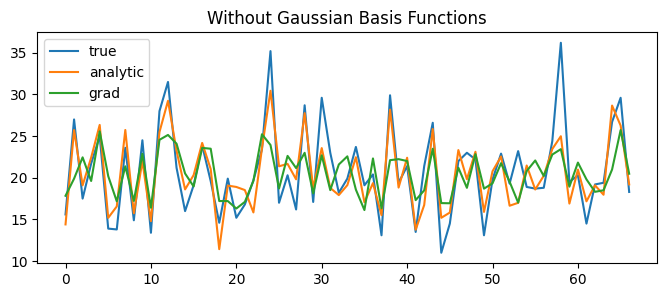

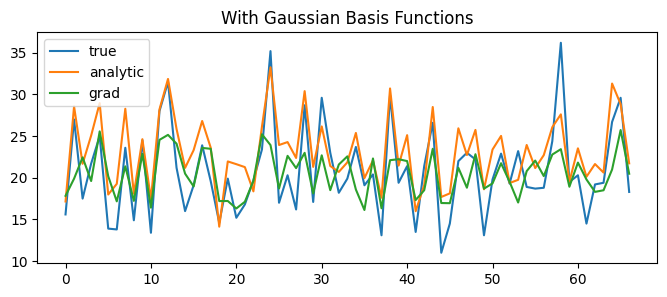

In [43]:
OPTIMIZER_KWARGS = {
    'batch_size': 32,
    'max_iters': 1e5,
    'learning_rate': 0.05,
    'verbose': False}


### Without Gaussian Basis Functions ###
# analytic fit
lin_reg = LinearRegression()
lin_reg.fit(X_housing_train, y_housing_train, analytic_fit=True, verbose=False)
y_preds_analytic = lin_reg.predict(X_housing_test)
ms_error_analytic = mse(y_housing_test, y_preds_analytic)

# mini-batch SGD fit
lin_reg = LinearRegression()
lin_reg.fit(X_housing_train, y_housing_train, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
y_preds_sgd = lin_reg.predict(X_housing_test)
ms_error_sgd = mse(y_housing_test, y_preds_sgd)

### With Gaussian Basis Functions ###
# analytic fit
lin_reg = LinearRegression()
lin_reg.fit(X_housing_train_gaussian, y_housing_train, analytic_fit=True, verbose=False)
y_preds_analytic_gaussian = lin_reg.predict(X_housing_test_gaussian)
ms_error_analytic_gaussian = mse(y_housing_test, y_preds_analytic_gaussian)

# mini-batch SGD fit
lin_reg = LinearRegression()
lin_reg.fit(X_housing_train_gaussian, y_housing_train, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
y_preds_sgd_gaussian = lin_reg.predict(X_housing_test_gaussian)
ms_error_sgd_gaussian = mse(y_housing_test, y_preds_sgd_gaussian)

print("Without Gaussian Basis Functions:")
print(f"Analytic Fit MSE: {ms_error_analytic:.3f}")
print(f"SGD Fit MSE: {ms_error_sgd:.3f}")
print("\nWith Gaussian Basis Functions:")
print(f"Analytic Fit MSE: {ms_error_analytic_gaussian:.3f}")
print(f"SGD Fit MSE: {ms_error_sgd_gaussian:.3f}")

plt.figure(figsize=(8,3))
plt.plot(y_housing_test, label='true')
plt.plot(y_preds_analytic, label='analytic')
plt.plot(y_preds_sgd, label='grad')
plt.title('Without Gaussian Basis Functions')
plt.legend()
plt.show()

plt.figure(figsize=(8,3))
plt.plot(y_housing_test, label='true')
plt.plot(y_preds_analytic_gaussian, label='analytic')
plt.plot(y_preds_sgd_gaussian, label='grad')
plt.title('With Gaussian Basis Functions')
plt.legend()
plt.show()

### Results

- adding Gaussian Basis Functions improved the SGD fit very slightly 
- significantly decreased the analytic fit
- in this specific context, may not be helpful when using an analytic method

# Experiment 8: Analytical vs. Mini-Batch Stochastic Gradient Descent
Only for dataset1, Compare analytical linear regression solution with mini-batch stochastic gradient descent- based linear regression solution. What do you find? Why do you think mini-batch stochastic gradient descent is used when an analytical solution is available?

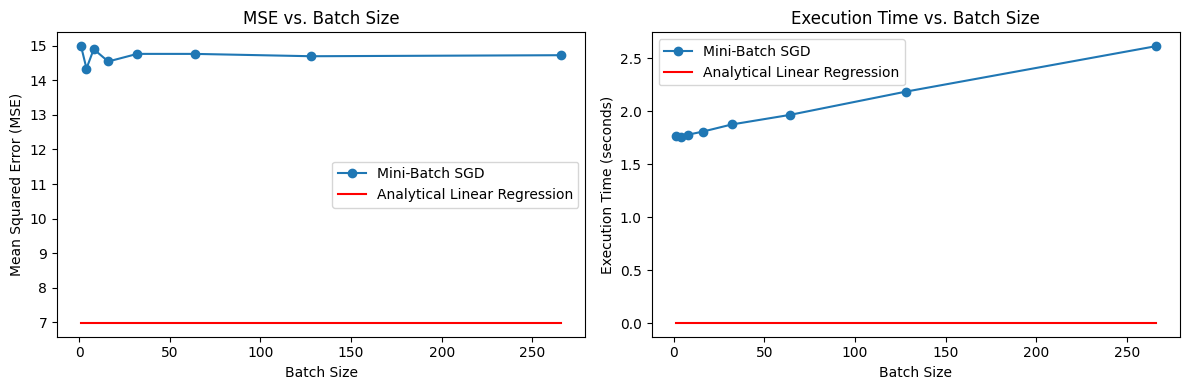

In [44]:
# Analytical Linear Regression
lin_reg_analytic = LinearRegression()

# Record start time for Analytical Linear Regression
start_time_analytic = time.time()

# Fit the model using the analytical method
lin_reg_analytic.fit(X_housing_train, y_housing_train, analytic_fit=True, verbose=False)

# Record end time for Analytical Linear Regression
end_time_analytic = time.time()

# Calculate MSE for Analytical Linear Regression
y_preds_analytic = lin_reg_analytic.predict(X_housing_test)
mse_analytic = mse(y_housing_test, y_preds_analytic)

# Initialize lists to store Analytical Linear Regression results
mse_analytic_values = [mse_analytic] * len(batch_sizes)
execution_times_analytic = [end_time_analytic - start_time_analytic] * len(batch_sizes)

# Add Analytical Linear Regression to the existing plots
plt.figure(figsize=(12, 4))

# Plot MSE values
plt.subplot(1, 2, 1)
plt.plot(batch_sizes, mse_values, marker='o', linestyle='-', label='Mini-Batch SGD')
plt.plot(batch_sizes, mse_analytic_values, linestyle='-', color='red', label='Analytical Linear Regression')
plt.title('MSE vs. Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()

# Plot execution times
plt.subplot(1, 2, 2)
plt.plot(batch_sizes, execution_times, marker='o', linestyle='-', label='Mini-Batch SGD')
plt.plot(batch_sizes, execution_times_analytic, linestyle='-', color='red', label='Analytical Linear Regression')
plt.title('Execution Time vs. Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Execution Time (seconds)')
plt.legend()

plt.tight_layout()
plt.show()


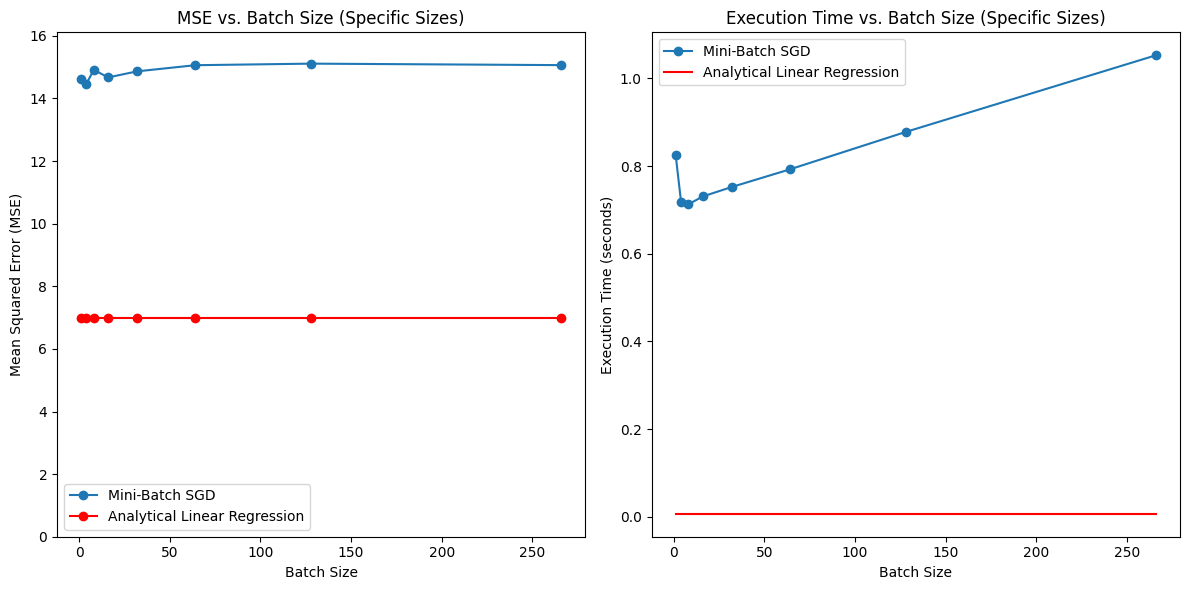

In [47]:
# Initialize lists to store MSE and time values for specific batch sizes
specific_batch_sizes = [1, 4, 8, 16, 32, 64, 128, X_housing_train.shape[0]]
specific_mse_values = []
specific_execution_times = []

# Analytical linear regression
lin_reg_analytic = LinearRegression()
start_time_analytic = time.time()
lin_reg_analytic.fit(X_housing_train, y_housing_train, analytic_fit=True, verbose=False)
end_time_analytic = time.time()
y_preds_analytic = lin_reg_analytic.predict(X_housing_test)
mse_analytic = mse(y_housing_test, y_preds_analytic)

# Calculate MSE and execution time for specific batch sizes
for batch_size in specific_batch_sizes:
    lin_reg_sgd = LinearRegression()
    start_time_sgd = time.time()
    lin_reg_sgd.fit(X_housing_train, y_housing_train, optimizer_class=StochasticGradientDescent, batch_size=batch_size, max_iters=4e4, learning_rate=0.1, verbose=False)
    end_time_sgd = time.time()
    y_preds_sgd = lin_reg_sgd.predict(X_housing_test)
    mse_sgd = mse(y_housing_test, y_preds_sgd)
    
    specific_mse_values.append(mse_sgd)
    specific_execution_times.append(end_time_sgd - start_time_sgd)

# Plot MSE and execution time for specific batch sizes
plt.figure(figsize=(12, 6))

# Plot MSE values
plt.subplot(1, 2, 1)
plt.plot(specific_batch_sizes, specific_mse_values, marker='o', linestyle='-', label='Mini-Batch SGD')
plt.plot(specific_batch_sizes, [mse_analytic] * len(specific_batch_sizes), linestyle='-', color='red', label='Analytical Linear Regression', marker='o')  # Added marker='o'
plt.title('MSE vs. Batch Size (Specific Sizes)')
plt.xlabel('Batch Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()

# Set the y-axis limits to show more values
plt.ylim(0, max(specific_mse_values) + 1)

# Plot execution times
plt.subplot(1, 2, 2)
plt.plot(specific_batch_sizes, specific_execution_times, marker='o', linestyle='-', label='Mini-Batch SGD')
plt.plot(specific_batch_sizes, [end_time_analytic - start_time_analytic] * len(specific_batch_sizes), linestyle='-', color='red', label='Analytical Linear Regression')
plt.title('Execution Time vs. Batch Size (Specific Sizes)')
plt.xlabel('Batch Size')
plt.ylabel('Execution Time (seconds)')
plt.legend()

plt.tight_layout()
plt.show()

## Based on experiments 1 & 4, we conclude the following data:
### Analytical Linear Regression:
MSE (Mean Squared Error): MSE = 6.983  
L2 Norm between Best Weights and SGD Weights: L2 norm = 5225.9  
Convergence speed: 0.00628 seconds  

### Mini-Batch Stochastic Gradient Descent (Batch Size 32):
MSE: MSE = 16.724  
Convergence Speed: 0.742 seconds  

## Comparison and Analysis:
The analytical linear regression solution has a lower MSE (6.983) compared to mini-batch SGD with a batch size of 32 (16.724). This indicates that, in this specific case, the analytical solution provides a more accurate model for the housing dataset.

However, it's important to consider the computational aspects and potential issues with the analytical solution:

As we know, finding the inverse matrix may be problematic if the determinant of the matrix (X^T)X is zero. While this wasn't the case in our experiment, ill-conditioned or singular matrices can arise in other scenarios, leading to numerical instability or outright failure when using the analytical method.

The L2 norm between the weights obtained from the analytical solution and the weights obtained from mini-batch SGD is quite large (5225.9). This suggests that the solutions are not identical, indicating that there might be some differences in regularization or handling of numerical stability in the two methods.

Mini-batch SGD, on the other hand, is a versatile and robust optimization method that can handle a wide range of scenarios:

- It is highly scalable and can handle large datasets efficiently.
- It can handle cases where the analytical solution may fail due to ill-conditioned matrices or numerical stability issues.

## Why Mini-Batch Stochastic Gradient Descent is Used When an Analytical Solution is Available:

Scalability: Mini-batch SGD can handle large datasets, making it suitable for big data scenarios where computing the analytical solution may be impractical.

Robustness: Mini-batch SGD is less sensitive to numerical stability issues and ill-conditioned matrices, making it a reliable choice for a wide range of datasets.

Regularization: It naturally supports regularization techniques, which can help prevent overfitting.

In summary, while analytical linear regression performs better because of its speed and accuracy for this dataset, mini-batch stochastic gradient descent remains a crucial tool. Its robustness and adaptability make it very useful, especially when handling large datasets that may pose computational challenges and scalability. The choice between these methods depends on the unique characteristics of the data and the practical demands of the task at hand.